In [1]:
from typing import Annotated
from typing_extensions import TypedDict

In [2]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [3]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10'

In [4]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [5]:
tools=[wiki_tool]

In [6]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [7]:
from langgraph.graph import StateGraph,START,END

In [8]:
graph_builder= StateGraph(State)


In [9]:
from langchain_groq import ChatGroq

In [10]:
import os
from dotenv import load_dotenv
load_dotenv()
groq_api_key=os.getenv("groq_api_key")

In [11]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002156F0B1070>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002156F0BA4F0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [12]:
llm_with_tools=llm.bind_tools(tools=tools)

In [13]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [14]:
from langgraph.prebuilt import ToolNode,tools_condition

In [15]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [16]:
graph=graph_builder.compile()

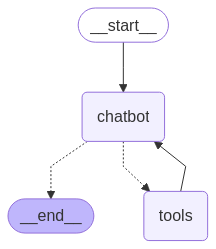

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
user_input="Hi there!, My name is John"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is John
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_x9cx)
 Call ID: call_x9cx
  Args:
    query: John


c:\Users\yashs\OneDrive\Desktop\New folder\LangGraph\myenv\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\yashs\OneDrive\Desktop\New folder\LangGraph\myenv\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_54c3)
 Call ID: call_54c3
  Args:
    query: John Doe
================================= Tool Message =================================
Name: wikipedia

Page: John Doe
Summary: John Doe (male) and Jane Doe (female) are multiple-use placeholder names that are used in the British and American legal system and assigned generally in the United Kingdom and the United States when the true name of a person is unknown or is being intentionally concealed. In
================================== Ai Message ==================================

Hi John, it's nice to meet you.


In [19]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_7ge0)
 Call ID: call_7ge0
  Args:
    query: RLHF
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine learning, reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other mo
================================== Ai Message ==================================

Reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other models to behave in ways that are more desi